In [42]:
import pandas as pd
import numpy as np

import os
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from prepare import prep_create_labels
from preprocess import prep_job_data, split_job_data, add_columns

# Wrangle the Data
- use functions from previous work to get a working train dataset

In [3]:
df = pd.read_json('indeed-data-jobs-FINAL.json')
df = prep_create_labels(df).reset_index(drop=True)
df = prep_job_data(df, 'job_description', extra_words=['job', 'description']).reset_index(drop=True)
df = add_columns(df)
df.sample(5)

/Users/brandmarz/data-science-projects/nlp-data-job-classifier/preprocess.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lemmatize)
/Users/brandmarz/data-science-projects/nlp-data-job-classifier/preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed'] = df[column].apply(basic_clean).apply(stem)
/Users/brandmarz/data-science-projects/nlp-data-job-classifier/preprocess.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,job_title,company,location,is_remote,salary,post_date,date_accessed,job_description,label,clean,stemmed,lemmatized,words,doc_length
154,"Data Scientist, Analytics",Castlight Health,"San Francisco, CA 94107",0,,9 days ago,2021-03-05,"Data Scientist, Analytics At Castlight Health,...",DS,data scientist analytics castlight health miss...,data scientist analyt at castlight health our ...,data scientist analytics at castlight health o...,"[data, scientist, analytics, castlight, health...",224
253,Data Analyst,CooperSurgical,"Boston, MA",0,,3 days ago,2021-03-05,We are looking for a Data Analyst to join Coop...,DA,looking data analyst join coopersurgical help ...,we are look for a data analyst to join coopers...,we are looking for a data analyst to join coop...,"[looking, data, analyst, join, coopersurgical,...",305
635,Machine Learning Engineer - Style Discovery,Stitch Fix,"San Francisco, CA",0,,30+ days ago,2021-03-05,"About the Team At Stitch Fix, we're transform...",MLE,team stitch fix transforming way people find l...,about the team at stitch fix were transform th...,about the team at stitch fix were transforming...,"[team, stitch, fix, transforming, way, people,...",385
246,Data Analyst,Kaizen Technologies,"Edison, NJ 08820",0,,1 day ago,2021-03-05,"Required Skills : TSQL, SQL Job Description :...",DA,required skill tsql sql ability write transact...,requir skill tsql sql job descript abil to wri...,required skill tsql sql job description abilit...,"[required, skill, tsql, sql, ability, write, t...",59
406,Data Engineer,DGN Technologies,Remote,1,Up to $60 an hour,22 days ago,2021-03-05,"Description: Data Engineer: Designs, builds an...",DE,data engineer design build oversees deployment...,descript data engin design build and overse th...,description data engineer design build and ove...,"[data, engineer, design, build, oversees, depl...",255


In [4]:
train, validate, test = split_job_data(df)
print(f'train: {round(train.shape[0]/len(df),2)}')
print(f'validate: {round(validate.shape[0]/len(df),2)}')
print(f'test: {round(test.shape[0]/len(df),2)}')

train: 0.6
validate: 0.2
test: 0.2


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 420 to 531
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       426 non-null    object
 1   job_title   426 non-null    object
 2   company     426 non-null    object
 3   location    426 non-null    object
 4   is_remote   426 non-null    int64 
 5   clean       426 non-null    object
 6   words       426 non-null    object
 7   doc_length  426 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 30.0+ KB


In [5]:
train.head()

,label,job_title,company,location,is_remote,clean,words,doc_length
420,DE,Data Engineer,"Stefanini, Inc","Richmond, VA",0,stefanini looking data engineer richmond va re...,"[stefanini, looking, data, engineer, richmond,...",216
250,DA,Financial Data Analyst (vehicle retail Domain),SILVERLINK TECHNOLOGIES LLC,"Bowling Green, KY",0,hiplease go let know interestjob title financi...,"[hiplease, go, let, know, interestjob, title, ...",64
426,DE,Data Engineer I or II - Can Be Remote Based On...,Associated Bank,"Milwaukee, WI",1,associated bank equal opportunity employer com...,"[associated, bank, equal, opportunity, employe...",366
170,DS,Associate Data Scientist,Gap Inc.,United States,0,gap inc brand bridge gap see world old navy de...,"[gap, inc, brand, bridge, gap, see, world, old...",337
581,MLE,Automation/Artificial Intelligence Machine Lea...,LOCKHEED MARTIN CORPORATION,"Littleton, CO 80125",0,coolest job planet lockheed martin space lockh...,"[coolest, job, planet, lockheed, martin, space...",499


### Number and % of Labels

In [12]:
labels = pd.concat([train.label.value_counts(),
                    train.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
DA,112,0.262911
MLE,108,0.253521
DS,103,0.241784
DE,103,0.241784


### Break up Words by Label

In [32]:
# change words in each label into a list
da_words = ' '.join(df[df.label == 'DA'].clean)
ds_words = ' '.join(df[df.label == 'DS'].clean)
de_words = ' '.join(df[df.label == 'DE'].clean)
mle_words = ' '.join(df[df.label == 'MLE'].clean)
all_words = ' '.join(df.clean)

In [33]:
# eliminate white space before and after text, then split into individual word strings
da_words = re.sub(r'\s.\s', '', da_words).split()
ds_words = re.sub(r'\s.\s', '', ds_words).split()
de_words = re.sub(r'\s.\s', '', de_words).split()
mle_words = re.sub(r'\s.\s', '', mle_words).split()
all_words = re.sub(r'\s.\s', '', all_words).split()

In [34]:
da_words

['independent',
 'contractordata',
 'analysthomeless',
 'management',
 'information',
 'system',
 'hmisthis',
 'contracted',
 'position',
 'employee',
 'king',
 'united',
 'waywho',
 'arekings',
 'united',
 'way',
 'serf',
 'hmis',
 'lead',
 'agency',
 'king',
 'tulare',
 'homeless',
 'management',
 'information',
 'system',
 'hmis',
 'hmis',
 'local',
 'information',
 'technology',
 'system',
 'used',
 'collect',
 'clientlevel',
 'data',
 'data',
 'provision',
 'housing',
 'service',
 'individual',
 'family',
 'experiencing',
 'homelessness',
 'hmis',
 'allows',
 'aggregation',
 'clientlevel',
 'data',
 'across',
 'service',
 'agency',
 'generate',
 'unduplicated',
 'count',
 'client',
 'served',
 'understand',
 'pattern',
 'service',
 'measure',
 'effectiveness',
 'homeless',
 'programsenvisioned',
 'scope',
 'servicesthe',
 'data',
 'analyst',
 'generate',
 'report',
 'provide',
 'information',
 'funders',
 'planner',
 'policy',
 'maker',
 'general',
 'community',
 'data',
 'used',


In [39]:
# transform each label string into a pandas Series
da_freq = pd.Series(da_words).value_counts()
ds_freq = pd.Series(ds_words).value_counts()
de_freq = pd.Series(de_words).value_counts()
mle_freq = pd.Series(mle_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [37]:
# combine all into a dataframe to work with
word_counts = (pd.concat([all_freq, ds_freq, da_freq, de_freq, mle_freq], axis=1, sort=True)
                .set_axis(['all', 'DS', 'DA', 'DE', 'MLE'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,DS,DA,DE,MLE
000,8,0,5,1,2
00035586,1,0,1,0,0
01,4,0,1,1,2
01mar2021pimco,1,0,0,0,1
02,7,3,2,1,1


# What are the most frequently occurring words?

In [38]:
word_counts.sort_values(by='all', ascending=False).head()

,all,DS,DA,DE,MLE
data,6280,1694,1561,2243,782
experience,2566,677,452,710,727
team,1832,541,363,400,528
work,1701,452,414,408,427
learning,1502,352,38,81,1031


- `data` is obvious, we're dealing with data jobs
- `experience` may need to be a stop word, all jobs will require experience
- `team` and `work` are probably good works to have in a resume
- `learning` is interesting, we can look for it more with deeper exploration

# Are there any words that uniquely identify each label?

In [41]:
pd.concat([word_counts[word_counts.DA == 0].sort_values(by='DA').tail(6),
           word_counts[word_counts.DS == 0].sort_values(by='DS').tail(6),
           word_counts[word_counts.DE == 0].sort_values(by='DE').tail(6),
           word_counts[word_counts.MLE == 0].sort_values(by='MLE').tail(6),
          ])

,all,DS,DA,DE,MLE
farming,1,0,0,0,1
farsipersian,1,1,0,0,0
fascinated,1,1,0,0,0
fascinating,3,1,0,0,2
fan,12,6,0,0,6
zurich,1,1,0,0,0
explorer,1,0,0,0,1
exporting,1,0,0,0,1
exportingbuilding,1,0,1,0,0
exposurehandicapped,1,0,1,0,0


There isn't any word that significantly differentiates one label from the other. Also, most of these words are probably specific to the company, location, etc. so this probably won't be helpful

Text(0.5, 1.0, 'Proportion of DS vs DA vs DE vs MLE for the 20 most common words')

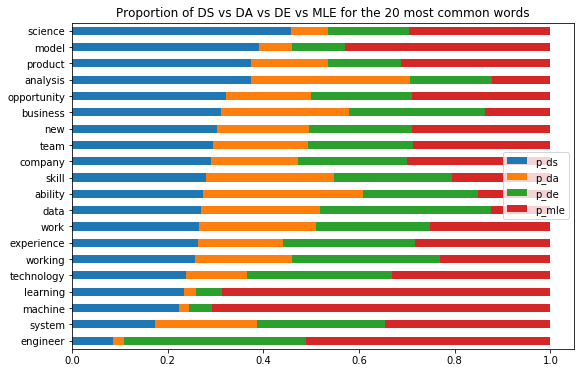

In [49]:
plt.rc('figure', figsize=(9,6))
(word_counts
 .assign(p_ds=word_counts.DS / word_counts['all'],
         p_da=word_counts.DA / word_counts['all'],
         p_de=word_counts.DE / word_counts['all'],
         p_mle=word_counts.MLE / word_counts['all'])
 .sort_values(by='all')
 [['p_ds', 'p_da', 'p_de', 'p_mle']]
 .tail(20)
 .sort_values('p_ds')
 .plot.barh(stacked=True))

plt.title('Proportion of DS vs DA vs DE vs MLE for the 20 most common words')

In [69]:
import itertools as it

combos = word_counts.columns.to_list()
combos.remove('all')
combos = it.combinations(combos, 2)

for i, n in combos:
    print(i, n)

DS DA
DS DE
DS MLE
DA DE
DA MLE
DE MLE


TypeError: 'itertools.combinations' object is not subscriptable

In [70]:
for i , n in combos:
    (word_counts
     [(word_counts.i > 10) & (word_counts.n > 10)]
     .assign(ratio=lambda df: df.i / (df.n + .01))
     .sort_values(by='ratio')
     .pipe(lambda df: pd.concat([df.head(), df.tail()])))

In [72]:
(word_counts
     [(word_counts.DS > 10) & (word_counts.DA > 10)]
     .assign(ratio=lambda train: train.DS / (train.DA + .01))
     .sort_values(by='ratio')
     .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,DS,DA,DE,MLE,ratio
analyst,382,30,299,45,8,0.100331
reporting,343,27,204,100,12,0.132346
excel,134,14,104,10,6,0.134602
report,360,36,245,62,17,0.146933
attention,87,13,51,17,6,0.254852
predictive,163,101,15,20,27,6.728847
algorithm,340,109,15,19,197,7.261825
learning,1502,352,38,81,1031,9.260721
machine,1110,247,24,53,786,10.287380
scientist,384,249,13,40,82,19.139124
